In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib import patches
import ipywidgets as widgets
sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_context('poster')
%matplotlib notebook

/Users/samdixon/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
data = pd.read_csv('./hw_2_data/flowers.csv')

In [3]:
def plot_features(feature_list, color_by):
    axes = []
    if color_by.dtype not in (int, float):
        categories = color_by.unique()
        palette = sns.color_palette(palette='husl', n_colors=len(categories))
        colormap = {cat: palette[i] for i, cat in enumerate(categories)}
        colors = [colormap[color] for color in color_by]
        handles = [patches.Patch(color=colormap[cat]) for cat in categories]
        labels = categories
    else:
        colormap = ScalarMappable(cmap='viridis')
        colormap.set_array(color_by)
        colors = colormap.to_rgba(color_by)
    n_features = len(feature_list)
    fig = plt.figure(figsize=(3*n_features, 3*n_features))
    for i in range(n_features):
        for j in range(i+1):
            ax = plt.subplot(n_features, n_features, n_features*i+j+1)
            ax.set_xlim(min(feature_list[j]), max(feature_list[j]))
            ax.set_ylim(min(feature_list[i]), max(feature_list[i]))
            ax.scatter(feature_list[j], feature_list[i], color=colors, linewidth=0)
            if j != 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            else:
                ax.set_ylabel(feature_list[i].name)
            if i != n_features-1:
                plt.setp(ax.get_xticklabels(), visible=False)
            else:
                ax.set_xlabel(feature_list[j].name)
            axes.append(ax)
    if color_by.dtype not in (int, float):
        fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.9, 0.9), title=color_by.name)
    else:
        fig.colorbar(colormap, ax=axes, label=color_by.name)
    return fig

In [5]:
class Brusher(object):
    
    def __init__(self, data, feature_list, color_by):
        self.data = data
        self.feature_list = feature_list
        self.color_by = color_by
        self.plot()
        
        self.x0 = None
        self.x1 = None
        self.y0 = None
        self.y1 = None
        self.select_axis = None
        self.rect = None
        self.cids = []
        self.is_pressed = False
        self.connect()
        
    def plot(self):
        self.axes_info = {}
        if self.color_by.dtype not in (int, float):
            categories = self.color_by.unique()
            palette = sns.color_palette(palette='husl', n_colors=len(categories))
            colormap = {cat: palette[i] for i, cat in enumerate(categories)}
            colors = [colormap[color] for color in self.color_by]
            handles = [patches.Patch(color=colormap[cat]) for cat in categories]
            labels = categories
        else:
            colormap = ScalarMappable(cmap='viridis')
            colormap.set_array(self.color_by)
            colors = colormap.to_rgba(self.color_by)
        n_features = len(self.feature_list)
        self.fig = plt.figure(figsize=(3*n_features, 3*n_features))
        for i in range(n_features):
            for j in range(i+1):
                ax = plt.subplot(n_features, n_features, n_features*i+j+1)
                ax.set_xlim(min(self.feature_list[j]), max(self.feature_list[j]))
                ax.set_ylim(min(self.feature_list[i]), max(self.feature_list[i]))
                ax.scatter(self.feature_list[j], self.feature_list[i], color=colors, linewidth=0)
                self.axes_info[ax] = [self.feature_list[j], self.feature_list[i]]
                if j != 0:
                    plt.setp(ax.get_yticklabels(), visible=False)
                else:
                    ax.set_ylabel(self.feature_list[i].name)
                if i != n_features-1:
                    plt.setp(ax.get_xticklabels(), visible=False)
                else:
                    ax.set_xlabel(self.feature_list[j].name)
        if self.color_by.dtype not in (int, float):
            self.fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.9, 0.9), title=self.color_by.name)
        else:
            self.fig.colorbar(colormap, ax=axes, label=self.color_by.name)
        
    def connect(self):
        self.cids.append(self.fig.canvas.mpl_connect('button_press_event', self.on_click))
        self.cids.append(self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion))
        self.cids.append(self.fig.canvas.mpl_connect('button_release_event', self.on_release))
        
    def on_click(self, event):
        if self.rect is not None:
            self.rect.remove()
        self.x0 = event.xdata
        self.y0 = event.ydata
        self.rect = patches.Rectangle((self.x0, self.y0), 0, 0, fc='k', alpha=0.1, linewidth=2)
        self.select_axis = event.inaxes
        self.select_axis.add_patch(self.rect)
        self.is_pressed = True
                
    def on_motion(self, event):
        if self.is_pressed and event.inaxes == self.select_axis:
            self.x1 = event.xdata
            self.y1 = event.ydata
            self.rect.set_width(self.x1 - self.x0)
            self.rect.set_height(self.y1 - self.y0)
            self.select_axis.draw_artist(self.rect)
            self.fig.canvas.blit(self.select_axis.bbox)

    def on_release(self, event):
        if self.is_pressed and event.inaxes == self.select_axis:
            self.x1 = event.xdata
            self.y1 = event.ydata
            self.rect.set_width(self.x1 - self.x0)
            self.rect.set_height(self.y1 - self.y0)
            self.select_axis.draw_artist(self.rect)
            self.fig.canvas.blit(self.select_axis.bbox)
        self.is_pressed = False
        self.get_data_from_selected_axis()
    
    def disconnect(self):
        [self.fig.canvas.mpl_disconnect(cid) for cid in cids]
        
    def get_data_from_selected_axis(self):
        self.x_series, y_series = self.axes_info[self.select_axis]
    
    def get_selected_data(self):
        pass
    
    def highlight_selected_data(self):
        pass

<IPython.core.display.Javascript object>


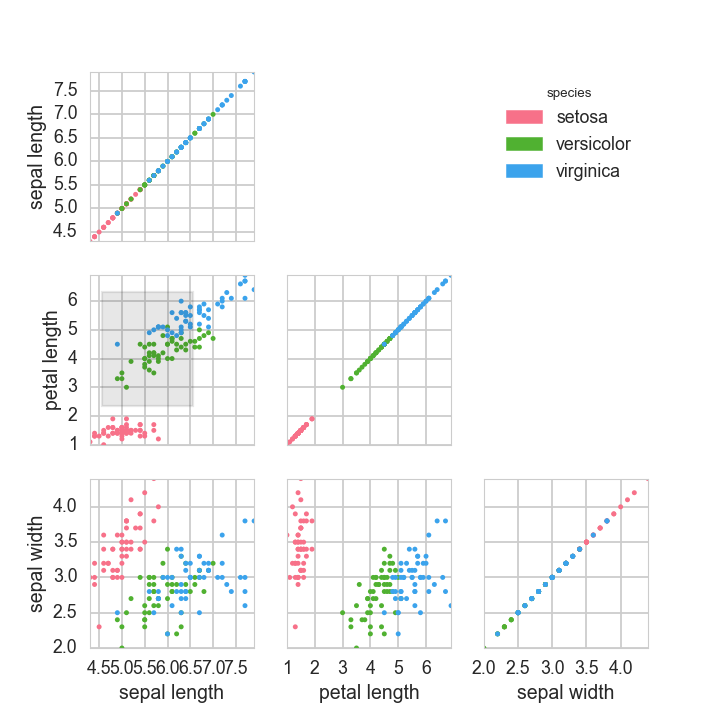

In [6]:
w = widgets.HTML()
feature_list = [data['sepal length'],
                data['petal length'],
                data['sepal width']]
b = Brusher(data, feature_list, color_by=data['species'])
w